In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd

In [2]:
apikey1 = '98WO4EK4CGOBTPQR'
apikey2 = '7HTSH49XTMKQSSUI'
premiumkey = 'D6W40P80TZPAE9QB'

In [3]:
#if i want to include SMA/stock data for same company, need to scrape function not just symbol
def TimeSeriesDaily_df(stock_name):
    """
    Read a CSV file from a URL and return a DataFrame with symbol as the last column.
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={stock_name}&outputsize=full&apikey={premiumkey}&datatype=csv'
    df = pd.read_csv(url)
    df['symbol'] = stock_name
    return df
    

In [4]:
#This one gives adjusted 
def TimeSeriesIntraday_df(stock_name):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={stock_name}&extended_hours=false&interval=1min&outputsize=full&apikey={premiumkey}&datatype=csv'
    df = pd.read_csv(url)
    df['symbol'] = stock_name
    return df
    

In [5]:
def QuoteEndpoint_df(stock_name):
    url = f'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={stock_name}&interval=1min&outputsize=full&apikey={apikey1}&datatype=csv'
    df = pd.read_csv(url)
    df['symbol'] = stock_name
    return df
    

In [6]:
daily_df = TimeSeriesDaily_df('TSLA')
daily_df

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,symbol
0,2025-10-16,434.75,439.3500,421.3101,428.75,428.750000,76666823,0.0,1.0,TSLA
1,2025-10-15,434.90,440.5100,426.3301,435.15,435.150000,71558185,0.0,1.0,TSLA
2,2025-10-14,426.79,434.2000,417.8600,429.24,429.240000,72669438,0.0,1.0,TSLA
3,2025-10-13,423.53,436.8900,419.7000,435.90,435.900000,79552785,0.0,1.0,TSLA
4,2025-10-10,436.54,443.1300,411.4500,413.49,413.490000,112107870,0.0,1.0,TSLA
...,...,...,...,...,...,...,...,...,...,...
3845,2010-07-06,20.00,20.0000,15.8300,16.11,1.074000,6866900,0.0,1.0,TSLA
3846,2010-07-02,23.00,23.1000,18.7100,19.20,1.280000,5139800,0.0,1.0,TSLA
3847,2010-07-01,25.00,25.9200,20.2700,21.96,1.464000,8218800,0.0,1.0,TSLA
3848,2010-06-30,25.79,30.4192,23.3000,23.83,1.588667,17187100,0.0,1.0,TSLA


In [7]:
max(np.array(daily_df['adjusted_close']))

np.float64(479.86)

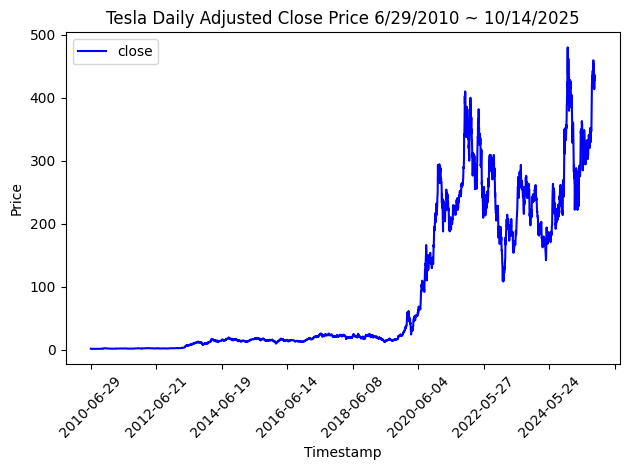

In [8]:
plt.plot(daily_df['timestamp'][::-1], daily_df['adjusted_close'][::-1], color='blue', label='close')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Tesla Daily Adjusted Close Price 6/29/2010 ~ 10/14/2025')
plt.legend()
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  

plt.tight_layout()
plt.show()

In [27]:
def get_daily_prices(portfolio):
    """
    Returns a DataFrame of close prices for the given portfolio.
    """
    data = {}
    for s in portfolio:
        df = TimeSeriesDaily_df(s)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.loc[df['timestamp'].dt.date > pd.Timestamp('2020, 10, 4').date()]
        prices = np.array(df['adjusted_close'])[::-1]
        data[s] = prices
    df_combined = pd.DataFrame(data)
    df_combined['mean'] = df_combined.mean(axis=1)
    price_arr = df_combined.to_numpy()
    price_arr = price_arr.T
    return_arr = (price_arr[:, 1:] - price_arr[:, :-1]) / price_arr[:, :-1] * 100
    return price_arr, return_arr

In [ ]:
def get_intraday_prices_chg(portfolio):
    """
    Returns a DataFrame of close prices for the given portfolio.
    """
    data = {}
    for s in portfolio:
        df = TimeSeriesIntraday_df(s)
        prices = np.array(df['close'])[::-1]
        data[s] = prices
    df_combined = pd.DataFrame(data)
    df_combined['mean'] = df_combined.mean(axis=1)
    price_arr = df_combined.to_numpy()
    price_arr = price_arr.T
    return_arr = (price_arr[:, 1:] - price_arr[:, :-1]) / price_arr[:, :-1] * 100
    return price_arr, return_arr

In [11]:
#home_construction_portfolio = ['DHI', 'LEN', 'PHM', 'TOL', 'NVR', 'HD', 'LOW', 'SHW', 'SPY']

In [25]:
portfolio_daily = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NDAQ']
portfolio = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']

In [26]:
daily_data, daily_chg_data = get_daily_prices(portfolio_daily)

1265
1265
1265
1265
1265
1265
1265
1265


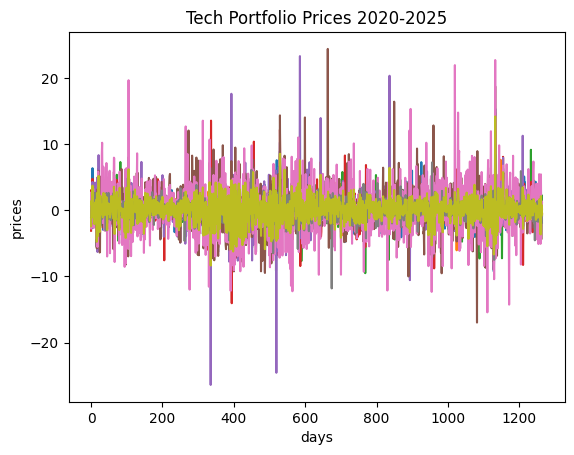

In [75]:
for s in daily_chg_data:
    plt.plot(s)
plt.title('Tech Portfolio Prices 2020-2025')
plt.ylabel('prices')
plt.xlabel('days')
plt.show()

In [29]:
def predict_price(M1, M2, l):
    ''' 
    Uses Koopman related DMD algorithm to predict future prices.
    l is the number of days in the future to predict
    ''' 
    U, s, Vt = np.linalg.svd(M1, full_matrices=False)
    Sigma_inv = np.diag(1.0/s)
    A_tilde = U.T @ M2 @ Vt.T @ Sigma_inv
    evals, evecs = np.linalg.eig(A_tilde)
    Phi = U @ evecs
    x0 = M1[:, 0].reshape((-1,1))
    b = np.linalg.pinv(Phi) @ x0

    n, r = Phi.shape
    preds = np.zeros((n, l))
    for t in range(1, l+1):
        D = np.diag(np.exp(np.log(evals) * t))
        x_t = Phi @ D @ b
        preds[:, t-1] = x_t.ravel().real
    
    return preds

In [30]:
def directional_accuracy(prediction, actual):
    '''
    Returns the accuracy of the predictions. The model is accurate if
    the predicted direction of the price change matches the actual direction.
    '''
    if prediction.shape != actual.shape:
        raise ValueError("Prediction and actual arrays must have the same shape.")

    diff_pred = prediction[:, 1:] - prediction[:, :-1]  
    diff_act = actual[:, 1:] - actual[:, :-1]     
    
    correct = np.sum((diff_pred * diff_act) > 0)
    return correct/diff_pred.size
    

In [31]:
def concat_data(accum, new_data):
    """
    Concatenate new_preds horizontally row by row to accum.
    Handles mixed dtypes by upcasting to object (or str if needed).
    """
    if accum is None:  
        return new_data.astype(object)

    accum = np.asarray(accum, dtype=object)
    new_data = np.asarray(new_data, dtype=object)

    return np.hstack((accum, new_data))

In [46]:
def find_hotspot(data_arr, m_start, m_end, l_start, l_end):
    ''' 
    Finds potential hotspots based on the directional accuracy of price predictions. 
    Uses past 100 days of data to run through a range of parameters (m, l) to find
    combinations that yield an accuracy greater than 0.53.

    Returns a list of tuples (m, l, accuracy) for all combinations tested.
    '''
    accuracy_scores = []
    potential_hotspots = []
    preds_array = []
    actuals_array = []
    hotspots = []
    scores = []
    averages = []

    for m in range(m_start, m_end):
        scores_m_temp = []
        for l in range(l_start, l_end):
            scores_l_temp = []
            predictions = None
            actuals = None

            for t in range(m, data_arr.shape[1]-l, l): 
                M = data_arr[:, t-m:t]
                M1 = M[:, :-1]
                M2 = M[:, 1:]
                preds = predict_price(M1, M2, l) 
                actual = data_arr[:, t:t+l]
                scores_l_temp.append(directional_accuracy(preds, actual))
                predictions = concat_data(predictions, preds)
                actuals = concat_data(actuals, actual)
            preds_array.append(predictions)
            actuals_array.append(actuals)
            accuracy = np.sum(scores_l_temp) / len(scores_l_temp) #the mean of all accuracy scores for a given (m, l)
            accuracy_scores.append((m, l, accuracy))
            scores_m_temp.append(accuracy)
            if accuracy > 0.52: #arbitrary threshold
                potential_hotspots.append((m, l, accuracy))
        scores.append(scores_m_temp)
    
    for m1, l1, acc in potential_hotspots:
        if (m1 == m_start) or (m1 == m_end-1) or (l1 == l_start) or (l1 == l_end-1):
            continue
        idx_m = m1 - m_start
        idx_l = l1 - l_start
        assert(acc == scores[idx_m][idx_l]), 'Wrong indexing for potential hotspot'
        avg = (scores[idx_m-1][idx_l-1] + scores[idx_m-1][idx_l] + scores[idx_m-1][idx_l+1] +
               scores[idx_m][idx_l-1] + scores[idx_m][idx_l] + scores[idx_m][idx_l+1] +
               scores[idx_m+1][idx_l-1] + scores[idx_m+1][idx_l] + scores[idx_m+1][idx_l+1]) / 9
        averages.append(avg)
        if avg * 100 >= 50.5:
            hotspots.append((m1, l1, acc, avg))
    
    sorted_hotspots = sorted(hotspots, key=lambda x: x[3], reverse=True) #x[2] to sort by individual acc score; x[3] to sort by average of neighbors acc scores

    return scores, potential_hotspots, sorted_hotspots, preds_array, actuals_array, accuracy_scores, averages

In [47]:
data_arr = daily_chg_data
m_start, m_end = 6, 30
l_start, l_end = 2, 10
data_arr_samp = data_arr #[:, 1200:1450]  # Assuming 252 trading days per year

In [48]:
scores, potential_hotspots, hotspots, preds_array, actuals_array, accuracy_scores, averages = find_hotspot(data_arr_samp, m_start, m_end, l_start, l_end)

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_93539/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))


In [49]:
len(potential_hotspots)

2

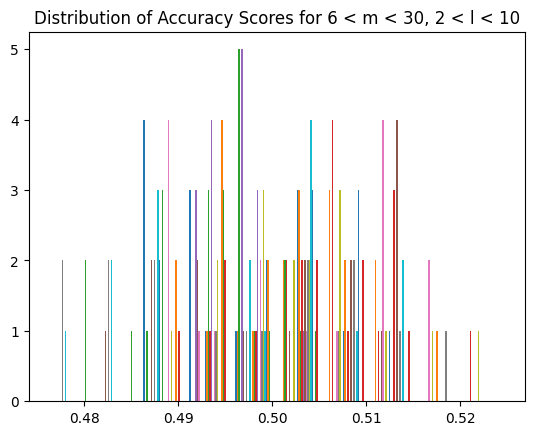

In [50]:
plt.hist(scores)
plt.title(f'Distribution of Accuracy Scores for {m_start} < m < {m_end}, {l_start} < l < {l_end}')
plt.show()

In [51]:
sorted_scores = sorted(accuracy_scores, key=lambda x: x[2], reverse=True)
sorted_scores[:5]


[(14, 3, np.float64(0.5249732905982906)),
 (9, 2, np.float64(0.5202906255537834)),
 (12, 5, np.float64(0.5175555555555555)),
 (14, 6, np.float64(0.517094017094017)),
 (12, 6, np.float64(0.5167735042735042))]

In [52]:
sorted_potential_hotspots = sorted(potential_hotspots, key=lambda x: x[2], reverse=True)
print("Top 5 potential hotspots:")
sorted_potential_hotspots[:5]

Top 5 potential hotspots:


[(14, 3, np.float64(0.5249732905982906)),
 (9, 2, np.float64(0.5202906255537834))]

In [39]:
def get_preds_and_actuals(m, l, m_start, l_start, l_end, preds, actuals, stock_num):
    ''' 
    Get my prediction values and the actual values, and plot them
    Args: 
        m: past days
        l: prediction horizon
        preds: preds_array from find_hospots
        actuals: actuals_array from find_hotspots
        stock_num (int): specific stock i want to see listed in portfolio
    '''
    diff = l_end - l_start
    idx = ((m - m_start) * diff) + (l - l_start)
    p, a = preds[idx][stock_num], actuals[idx][stock_num]

    plt.plot(p, color='blue', label='preds')
    plt.plot(a, color='red', label='actual')
    plt.title(f'Prediction vs. Actual Prices m={m}, l={l}, stock={portfolio[stock_num]}')
    plt.legend()
    plt.show()

    return preds[idx], actuals[idx]
    

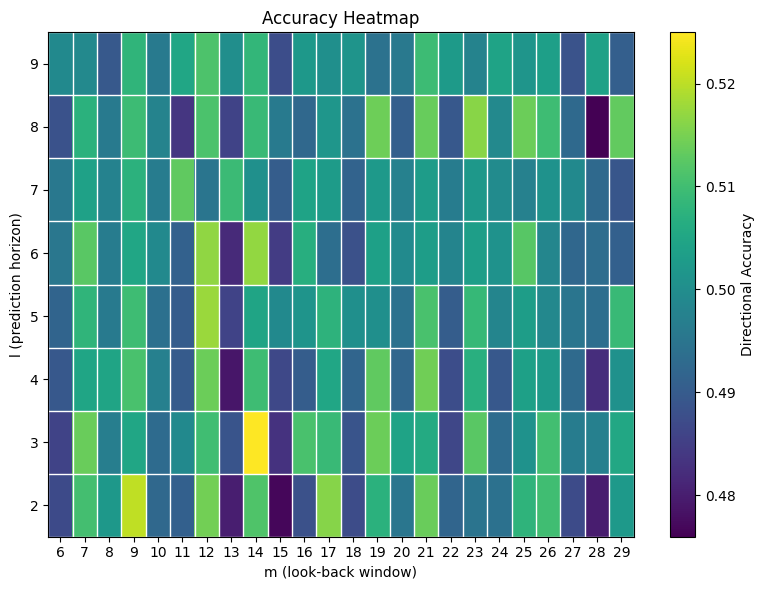

In [40]:
ms = sorted({m for m, l, score in accuracy_scores})
ls = sorted({l for m, l, score in accuracy_scores})

heatmap = np.zeros((len(ls), len(ms)))

for (m_val, l_val, score) in accuracy_scores:
    i = ls.index(l_val)   
    j = ms.index(m_val) 
    heatmap[i, j] = score

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heatmap, origin='lower', aspect='auto')

ax.set_xticks(np.arange(len(ms)))
ax.set_xticklabels(ms)
ax.set_yticks(np.arange(len(ls)))
ax.set_yticklabels(ls)

ax.set_xticks(np.arange(len(ms) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(ls) + 1) - 0.5, minor=True)

ax.grid(which='minor', color='white', linestyle='-', linewidth=1)

ax.tick_params(which='minor', bottom=False, left=False)

ax.set_xlabel('m (look-back window)')
ax.set_ylabel('l (prediction horizon)')
ax.set_title('Accuracy Heatmap')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Directional Accuracy')

plt.tight_layout()
plt.show()

In [41]:
sorted_potential_hotspots = sorted(potential_hotspots, key=lambda x: x[2], reverse=True)
print("Top 5 potential hotspots:")
sorted_potential_hotspots[:5]

Top 5 potential hotspots:


[(14, 3, np.float64(0.5249732905982906)),
 (9, 2, np.float64(0.5202906255537834))]

In [53]:
sorted_hotspots_ind = sorted(hotspots, key=lambda x: x[2], reverse=True)
sorted_hotspots_avg = sorted(hotspots, key=lambda x: x[3], reverse=True)

print(f'Top5 individual hotspots: \n {sorted_hotspots_ind[:5]}')
print(f'Top 5 neighbor avg hotspots: \n {sorted_hotspots_avg[:5]}')


Top5 individual hotspots: 
 []
Top 5 neighbor avg hotspots: 
 []


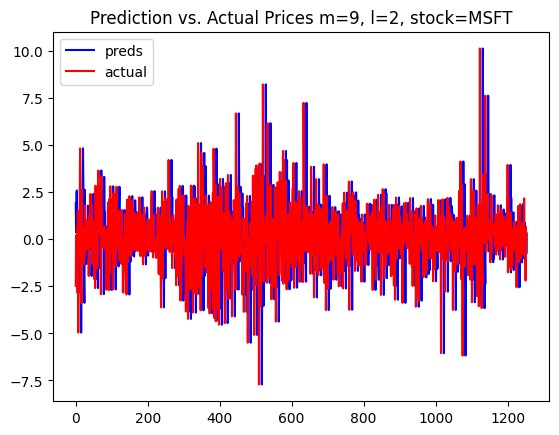

In [54]:
preds, actuals = get_preds_and_actuals(9, 2, m_start, l_start, l_end, preds_array, actuals_array, 1)

Try on intraday (if we train on last year or so of daily prices, might be different regimes to use for future predictions).

**Dynamic Strategy**

In [55]:
def simulate_dynamic_strategy(
    bankroll, 
    data_arr,           # <- this is daily_data (prices)
    daily_chg_data,     # <- this is percent change data
    window_len, 
    m_start, m_end, 
    l_start, l_end
):
    """
    Simulate trades using a rolling window hotspot strategy.
    Hotspot discovery is done on percent change data (daily_chg_data),
    but PnL is computed using actual price data (data_arr).
    """

    n_stocks = data_arr.shape[0] - 1
    total_days = data_arr.shape[1]  # assumes both data arrays are aligned

    day = window_len
    total_pnl = 0.0
    trade_log = []

    while day + 1 < total_days:
        # 1. Look back `window_len` days of percent change data
        train_data = daily_chg_data[:, day - window_len: day]
        _, _, hotspots, _, _, _, _ = find_hotspot(train_data, m_start, m_end, l_start, l_end)

        if not hotspots:
            day += 1
            continue

        # 2. Pick best hotspot
        m, l, acc, avg = max(hotspots, key=lambda x: x[2])

        if day + l >= total_days:
            break  # not enough future data to simulate trade

        # 3. Build prediction input matrices from percent changes
        M = daily_chg_data[:n_stocks, day - m: day]
        M1, M2 = M[:, :-1], M[:, 1:]
        pred = predict_price(M1, M2, l)  # prediction in percent change space

        # Use actual prices for pnl calculation
        actual = data_arr[:n_stocks, day: day + l]

        # Must have valid predictions and prices
        valid_idx = ~np.isnan(pred[:, 0]) & ~np.isnan(pred[:, -1]) & \
                    ~np.isnan(actual[:, 0]) & ~np.isnan(actual[:, -1])
        if not np.any(valid_idx):
            day += 1
            continue

        # 4. Determine trade direction from predicted net change over l days
        delta = pred[valid_idx, -1] - pred[valid_idx, 0]
        direction = np.sign(delta)
        if np.all(direction == 0):
            day += 1
            continue

        # 5. Execute trade using actual price data
        entry_prices = actual[:, 0][valid_idx]
        exit_prices  = actual[:, -1][valid_idx]

        per_stock_investment = bankroll / len(entry_prices)
        pnl = 0.0

        for j in range(len(entry_prices)):
            entry = entry_prices[j]
            exit_ = exit_prices[j]
            dir_j = direction[j]
            if dir_j == 0:
                continue
            stock_return = (exit_ - entry) if dir_j > 0 else (entry - exit_)
            pnl += stock_return / entry * per_stock_investment

        total_pnl += pnl
        trade_log.append({
            "entry_day": day,
            "exit_day": day + l - 1,
            "m": m,
            "l": l,
            "accuracy": acc,
            "avg_neighbor_accuracy": avg,
            "pnl": pnl,
        })

        # 6. Advance by l days after a trade
        day += l

    return total_pnl, trade_log


In [57]:
window_len = 150
dynamic_pnl, dynamic_trades = simulate_dynamic_strategy(
    bankroll=1000,
    data_arr=daily_data,
    daily_chg_data = daily_chg_data,
    window_len = window_len,
    m_start = m_start,
    m_end = m_end,
    l_start = l_start,
    l_end = l_end
)


/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_93539/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))


In [58]:
dynamic_pnl

np.float64(-14.343270412400415)

In [59]:
dynamic_m_used = [trade['m'] for trade in dynamic_trades]
dynamic_l_used = [trade['l'] for trade in dynamic_trades]
dynamic_unit_pnl = [trade['pnl'] for trade in dynamic_trades]

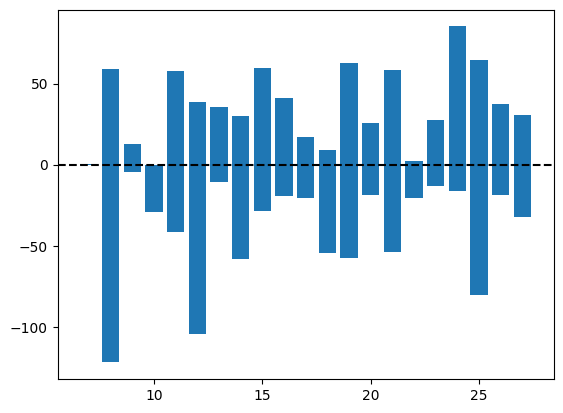

In [60]:
plt.bar(dynamic_m_used, dynamic_unit_pnl)
plt.axhline(y=0, linestyle='--', color='black')
plt.show()

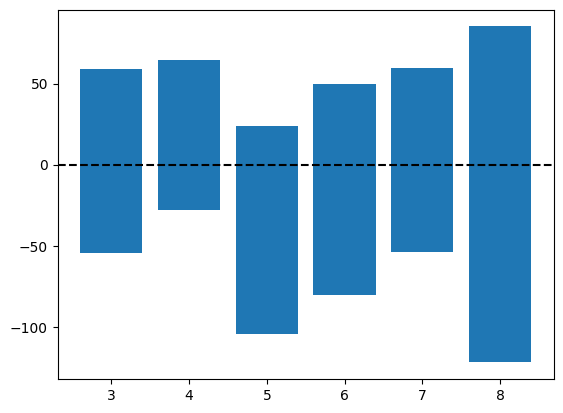

In [62]:
plt.bar(dynamic_l_used, dynamic_unit_pnl)
plt.axhline(y=0, linestyle='--', color='black')
plt.show()

In [63]:
print(f'window length: {window_len}')
print(f'Dynamic PnL: {dynamic_pnl:.2f} \nTotal Trades: {len(dynamic_trades)}')

window length: 150
Dynamic PnL: -14.34 
Total Trades: 206


In [64]:
def plot_pnl(trade_log):
    """
    Plots cumulative PnL over time based on the trade log.
    
    Arguments:
        trade_log (list of dict): Output from simulate_pnl(), each dict contains 'entry_day' and 'pnl'
    """
    if not trade_log:
        print("No trades to plot.")
        return

    days = []
    pnl_cumsum = []
    running_total = 0.0

    for trade in trade_log:
        days.append(trade["exit_day"])
        running_total += trade["pnl"]
        pnl_cumsum.append(running_total)

    plt.plot(days, pnl_cumsum, marker='o', linestyle='-')
    plt.xlabel("Trading Day")
    plt.ylabel("Cumulative PnL ($)")
    plt.title("Cumulative PnL Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

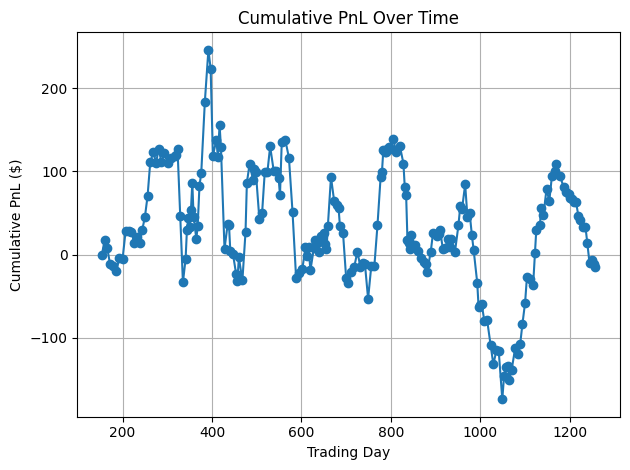

In [65]:
plot_pnl(dynamic_trades)

**Static Stratgy**

In [66]:
def simulate_static_strategy(
    bankroll,
    data_arr,
    percent_change_arr,
    window_len,
    step_n,
    m_start,
    m_end,
    l_start,
    l_end
):
    """
    Runs a fixed-hotspot strategy where the best hotspot is re-selected every `step_n` days.
    Prediction is based on percent change data, but PnL is calculated using actual prices.

    Parameters:
        bankroll (float): Total capital to invest.
        data_arr (np.ndarray): Shape [n_stocks+1, n_days], actual price data with mean row.
        percent_change_arr (np.ndarray): Same shape, percent changes for prediction.
        window_len (int): Length of historical window to search for hotspots.
        step_n (int): Number of days to hold using the selected hotspot before re-selecting.
        m_start, m_end: Range for m values to search.
        l_start, l_end: Range for l values to search.

    Returns:
        total_pnl (float): Accumulated PnL.
        trade_log (list): Each trade window’s summary.
    """

    n_stocks = data_arr.shape[0] - 1
    total_days = data_arr.shape[1]
    day = window_len
    total_pnl = 0.0
    trade_log = []

    while day + step_n < total_days:
        # 1. Select best hotspot from historical window (on percent change data)
        train_data = percent_change_arr[:, day - window_len : day]
        scores, potential_hotspots, hotspots, preds_array, actuals_array, _, _ = find_hotspot(
            train_data, m_start, m_end, l_start, l_end
        )
        
        if not hotspots:
            day += step_n
            continue  # No hotspot found, skip this window

        # 2. Pick best hotspot by highest accuracy
        best = max(hotspots, key=lambda x: x[2])  # (m, l, acc, avg)
        m, l, acc, avg = best

        # 3. Start trading using (m, l) for next step_n days
        for t in range(day, day + step_n - l + 1, l):
            if t - m < 0 or t + l > total_days:
                continue

            # Predict on percent change data
            M = percent_change_arr[:n_stocks, t - m : t]
            M1 = M[:, :-1]
            M2 = M[:, 1:]
            pred = predict_price(M1, M2, l)
            if np.isnan(pred).any() or np.isinf(pred).any():
                continue

            # Actual price data for PnL
            actual = data_arr[:n_stocks, t : t + l]

            valid_idx = ~np.isnan(pred[:, -1]) & ~np.isnan(pred[:, 0]) & \
                        ~np.isnan(actual[:, 0]) & ~np.isnan(actual[:, -1])
            if not np.any(valid_idx):
                continue

            delta = pred[valid_idx, -1] - pred[valid_idx, 0]
            direction = np.sign(delta)
            if np.all(direction == 0):
                continue

            entry_prices = actual[:, 0][valid_idx]
            exit_prices  = actual[:, -1][valid_idx]

            per_stock_investment = bankroll / len(entry_prices)
            pnl = 0.0

            for j in range(len(entry_prices)):
                entry = entry_prices[j]
                exit_ = exit_prices[j]
                dir_j = direction[j]
                if dir_j == 0:
                    continue
                if entry <= 0 or np.isnan(entry) or np.isnan(exit_):
                    continue
                stock_return = (exit_ - entry) if dir_j > 0 else (entry - exit_)
                pnl += stock_return / entry * per_stock_investment

            total_pnl += pnl
            trade_log.append({
                "entry_day": t,
                "exit_day": t + l - 1,
                "m": m,
                "l": l,
                "accuracy": acc,
                "avg_neighbor_accuracy": avg,
                "pnl": pnl,
            })

        # 4. Advance by `step_n` days and repeat
        day += step_n

    return total_pnl, trade_log, (total_days - window_len)


/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_93539/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))


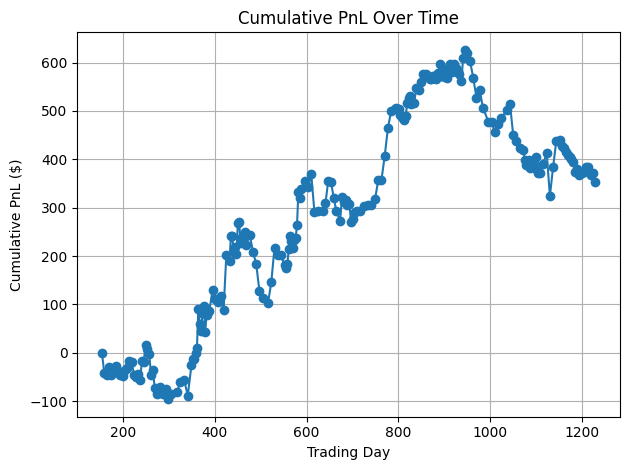

In [67]:
training_window = 150
test_window = 40
static_pnl, static_trades, available_trading_days = simulate_static_strategy(
    bankroll=1000,
    data_arr=daily_data,
    percent_change_arr = daily_chg_data,
    window_len=training_window, #test different window_len
    step_n=test_window, #test different step_n
    m_start=5,
    m_end=30,
    l_start=2,
    l_end=10
)

plot_pnl(static_trades)


In [68]:
pnl = [trade['pnl'] for trade in static_trades]
np.var(pnl)

np.float64(656.700513745207)

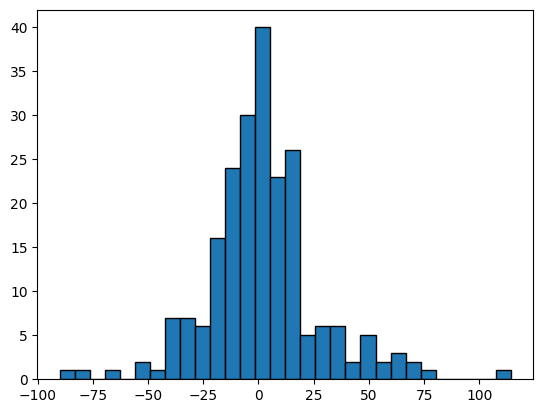

In [69]:
plt.hist(pnl, edgecolor='black', bins=30)
plt.show()

In [70]:
print(f'Train Window: {training_window}')
print(f'Test Window: {test_window:.2f}')
print(f'Static PnL: {static_pnl:.2f}')
print(f'Total Trades: {len(static_trades)}')


Train Window: 150
Test Window: 40.00
Static PnL: 353.87
Total Trades: 218


Testing for Different Train and Test Windows for Static Strategy

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_93539/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))


train window: 100, test window: 20
PnL: -99.37110826007229
Mean Unit PnL: -0.45
Total Trades: 220


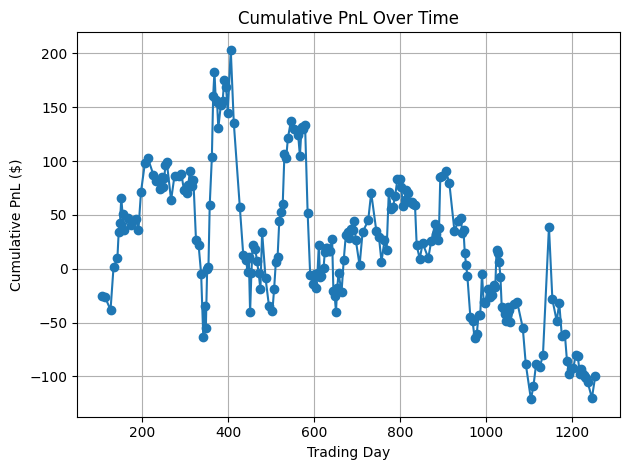

train window: 100, test window: 30
PnL: -26.36652059008763
Mean Unit PnL: -0.11
Total Trades: 236


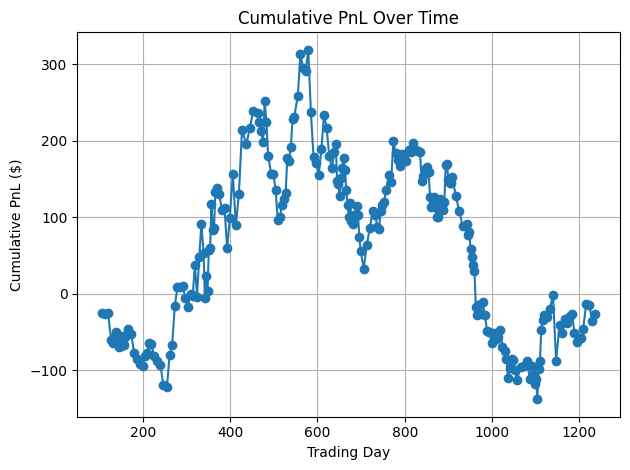

train window: 100, test window: 40
PnL: -341.27309804162843
Mean Unit PnL: -1.45
Total Trades: 236


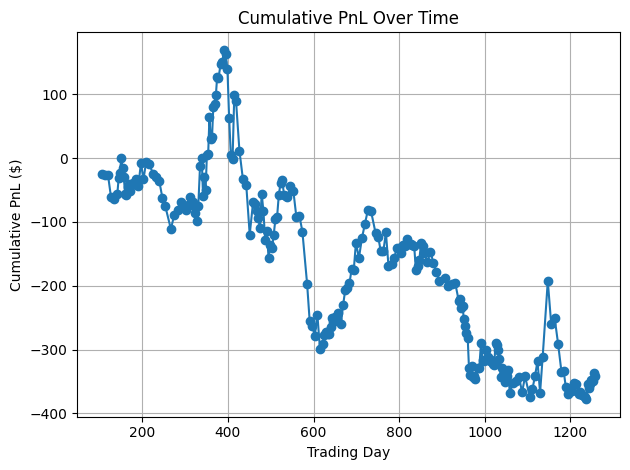

train window: 100, test window: 50
PnL: 668.504346289565
Mean Unit PnL: 2.73
Total Trades: 245


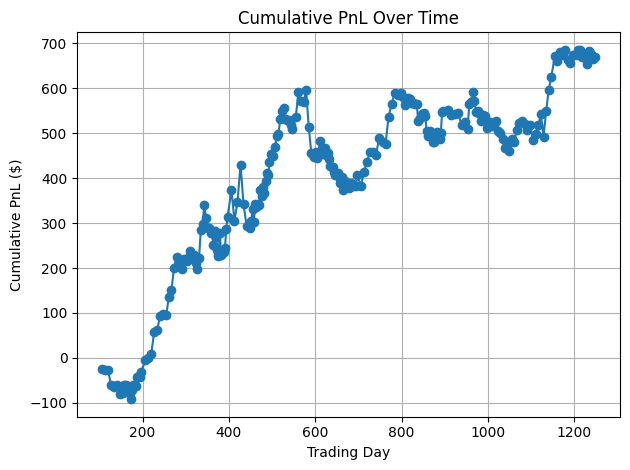

train window: 100, test window: 60
PnL: -286.91354222266034
Mean Unit PnL: -1.21
Total Trades: 237


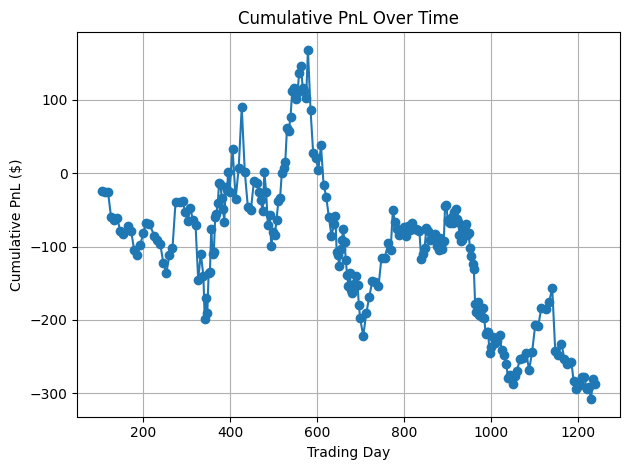

train window: 150, test window: 20
PnL: 439.0039479851853
Mean Unit PnL: 2.07
Total Trades: 212


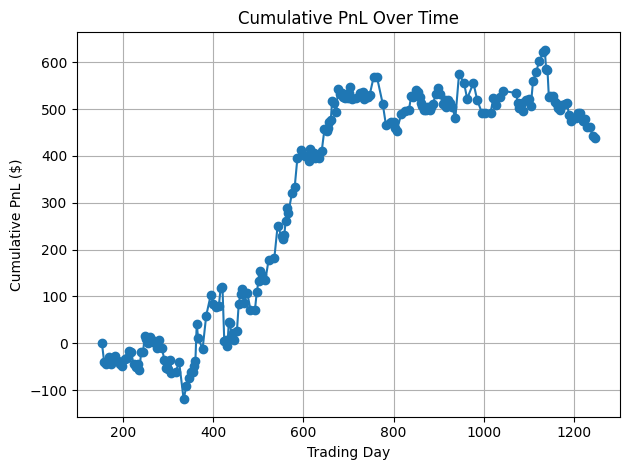

train window: 150, test window: 30
PnL: 76.17170395980715
Mean Unit PnL: 0.38
Total Trades: 200


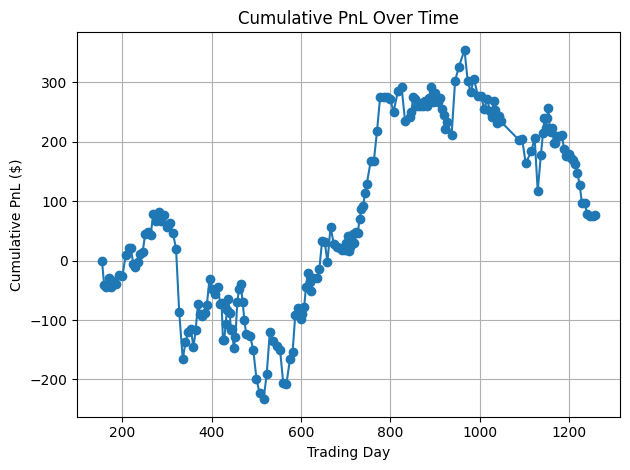

train window: 150, test window: 40
PnL: 353.8652844182252
Mean Unit PnL: 1.62
Total Trades: 218


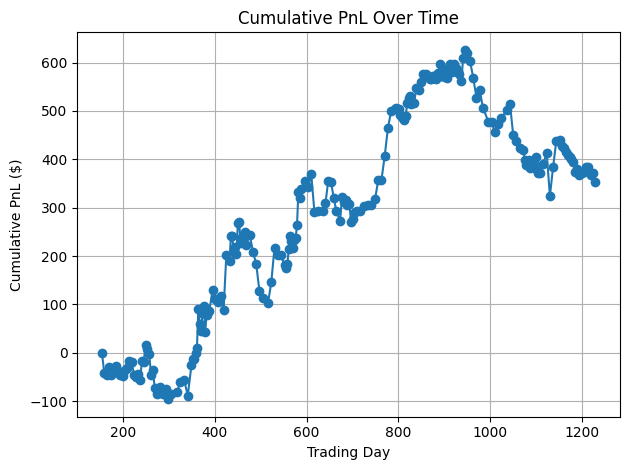

train window: 150, test window: 50
PnL: 88.29948156708114
Mean Unit PnL: 0.35
Total Trades: 249


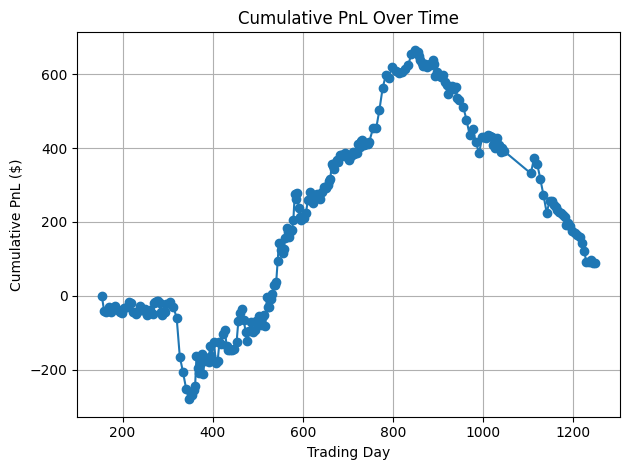

train window: 150, test window: 60
PnL: 934.1724310293932
Mean Unit PnL: 5.00
Total Trades: 187


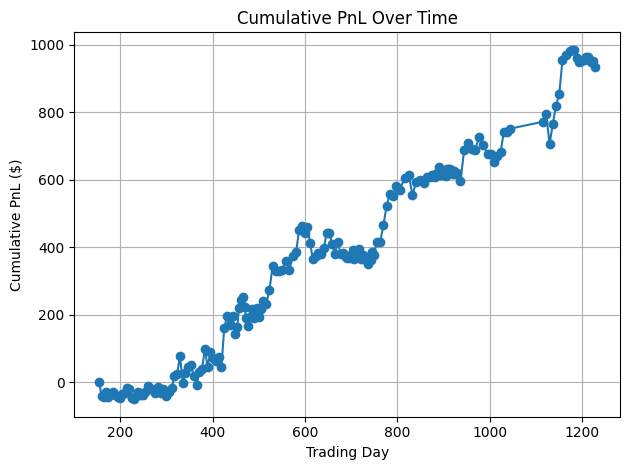

train window: 200, test window: 20
PnL: 352.76951061187754
Mean Unit PnL: 1.70
Total Trades: 207


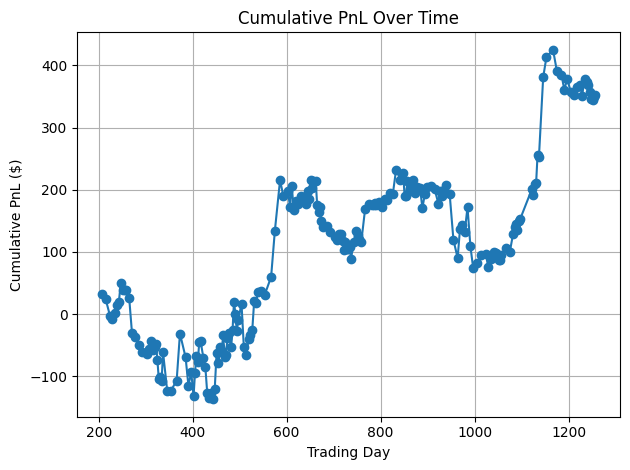

train window: 200, test window: 30
PnL: 110.3391306069019
Mean Unit PnL: 0.55
Total Trades: 202


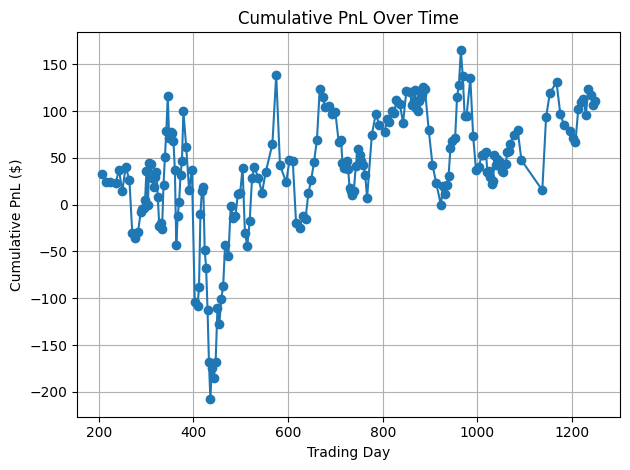

train window: 200, test window: 40
PnL: 669.6610480312256
Mean Unit PnL: 2.83
Total Trades: 237


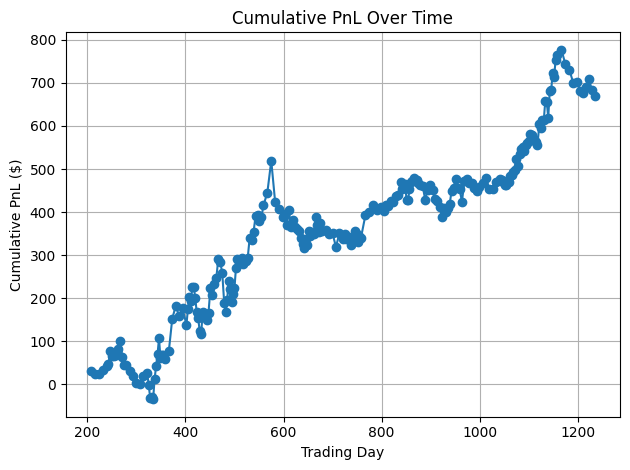

train window: 200, test window: 50
PnL: 423.80289028088885
Mean Unit PnL: 2.04
Total Trades: 208


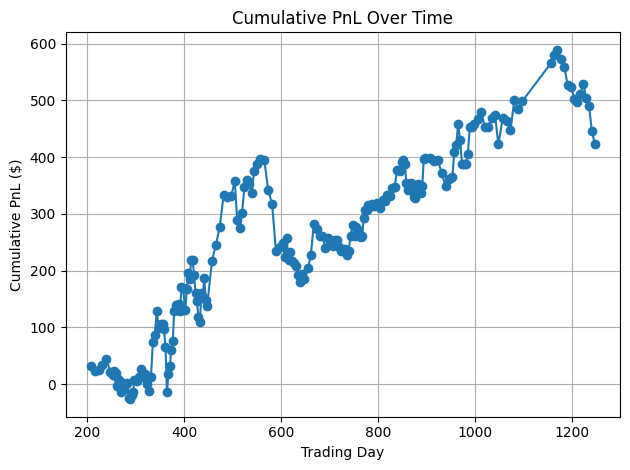

train window: 200, test window: 60
PnL: 145.14951940991892
Mean Unit PnL: 0.73
Total Trades: 198


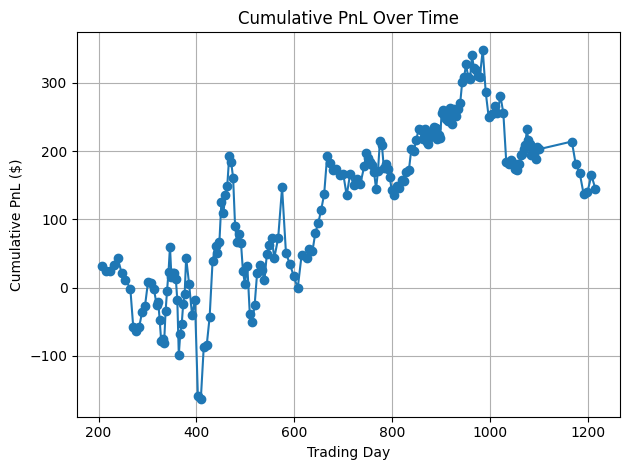

train window: 250, test window: 20
PnL: 291.4879058276881
Mean Unit PnL: 1.88
Total Trades: 155


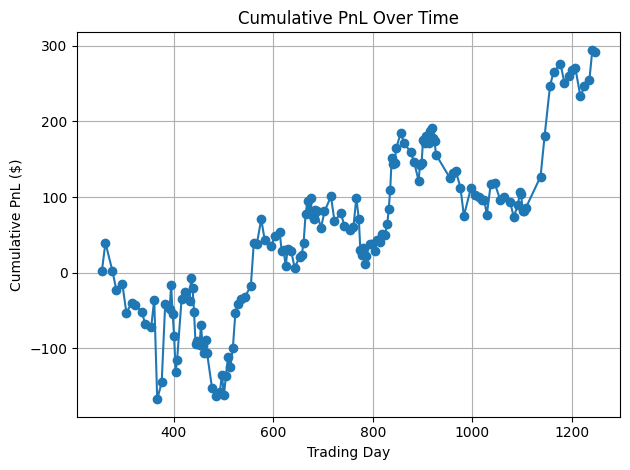

train window: 250, test window: 30
PnL: 345.08221000450635
Mean Unit PnL: 1.78
Total Trades: 194


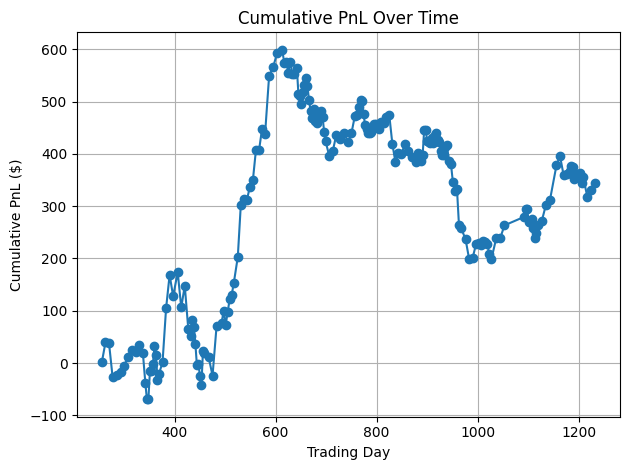

train window: 250, test window: 40
PnL: 296.9706241545116
Mean Unit PnL: 1.72
Total Trades: 173


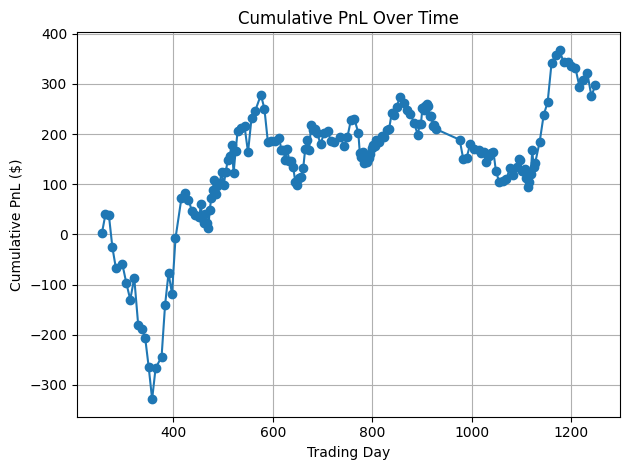

train window: 250, test window: 50
PnL: 64.71566348922975
Mean Unit PnL: 0.35
Total Trades: 184


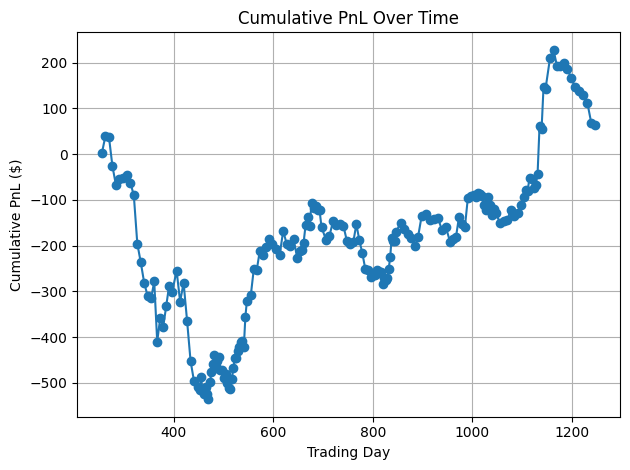

train window: 250, test window: 60
PnL: 317.354473125525
Mean Unit PnL: 1.63
Total Trades: 195


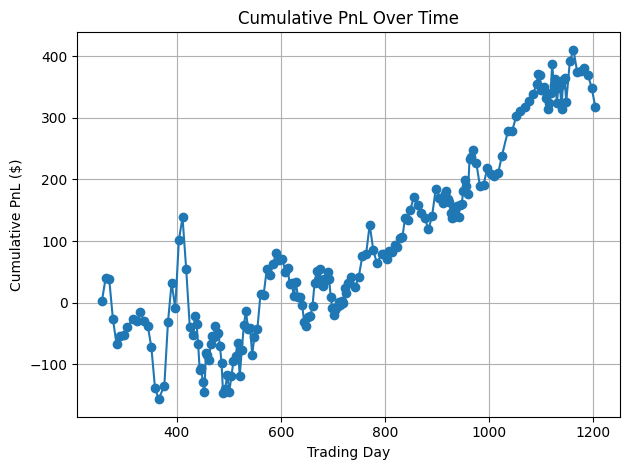

train window: 300, test window: 20
PnL: -439.16494508297626
Mean Unit PnL: -3.43
Total Trades: 128


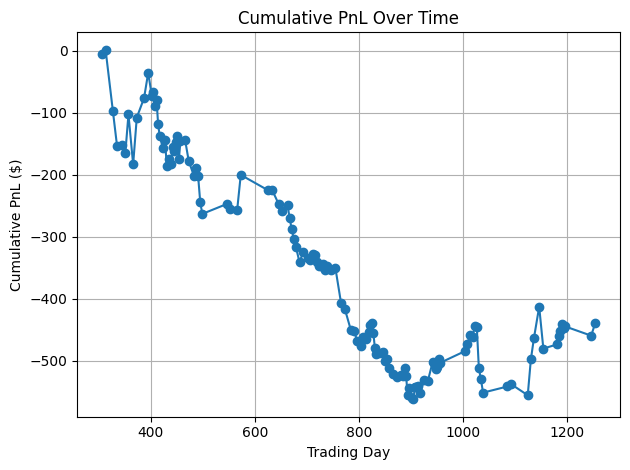

train window: 300, test window: 30
PnL: -365.64407840989344
Mean Unit PnL: -2.30
Total Trades: 159


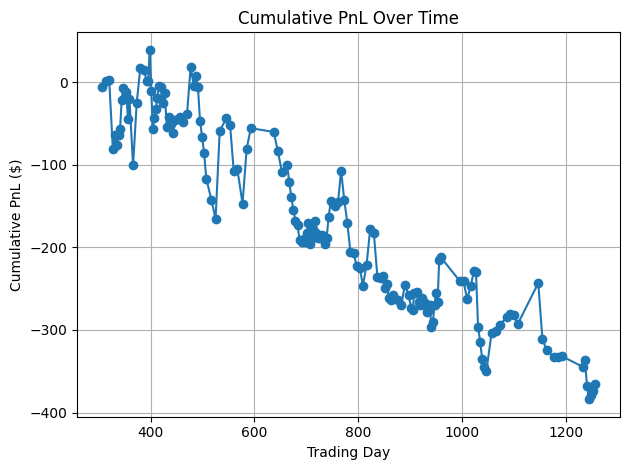

train window: 300, test window: 40
PnL: -152.59141046771288
Mean Unit PnL: -1.06
Total Trades: 144


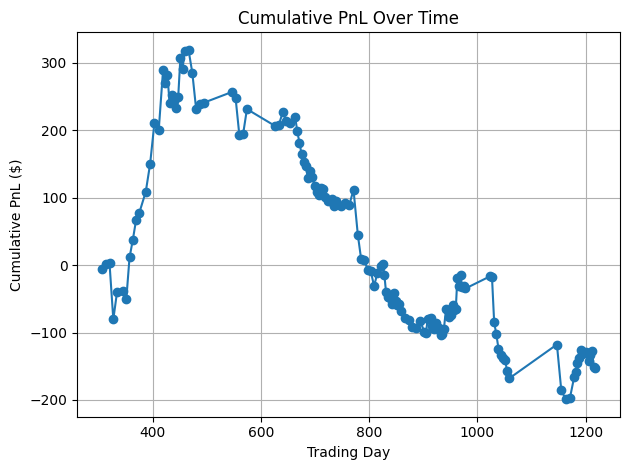

train window: 300, test window: 50
PnL: -96.08935711305539
Mean Unit PnL: -0.70
Total Trades: 137


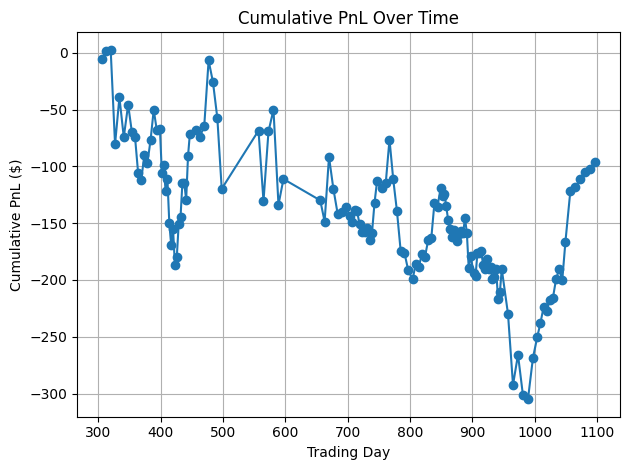

train window: 300, test window: 60
PnL: -212.98654901955283
Mean Unit PnL: -1.34
Total Trades: 159


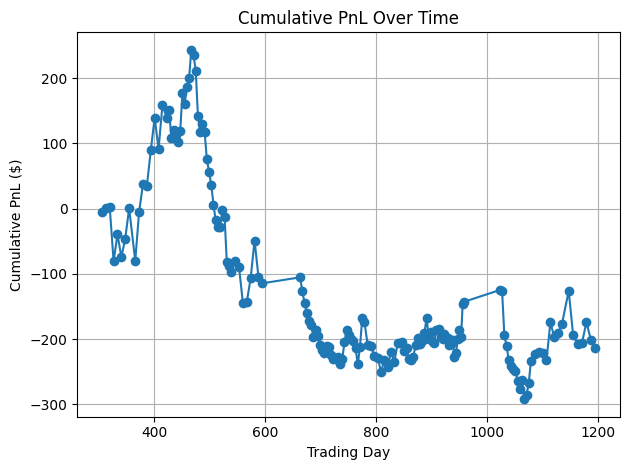

In [72]:
train_windows = [100, 150, 200, 250, 300]
test_windows = [20, 30, 40, 50, 60]
result = []

for train in train_windows:
    train_result = []
    for test in test_windows:
        if train < test:
            continue
        static_pnl, static_trades, available_trading_days = simulate_static_strategy(
        bankroll=1000,
        data_arr=daily_data,
        percent_change_arr = daily_chg_data,
        window_len=train, 
        step_n=test, 
        m_start=5,
        m_end=30,
        l_start=2,
        l_end=10
        )
        pnl = [trade['pnl'] for trade in static_trades]
        train_result.append((train, test, static_pnl, pnl))
        print(f'train window: {train}, test window: {test}')
        print(f'PnL: {static_pnl}')
        print(f'Mean Unit PnL: {np.mean(pnl):.2f}')
        print(f'Total Trades: {len(static_trades)}')
        plot_pnl(static_trades)
    result.append(train_result)


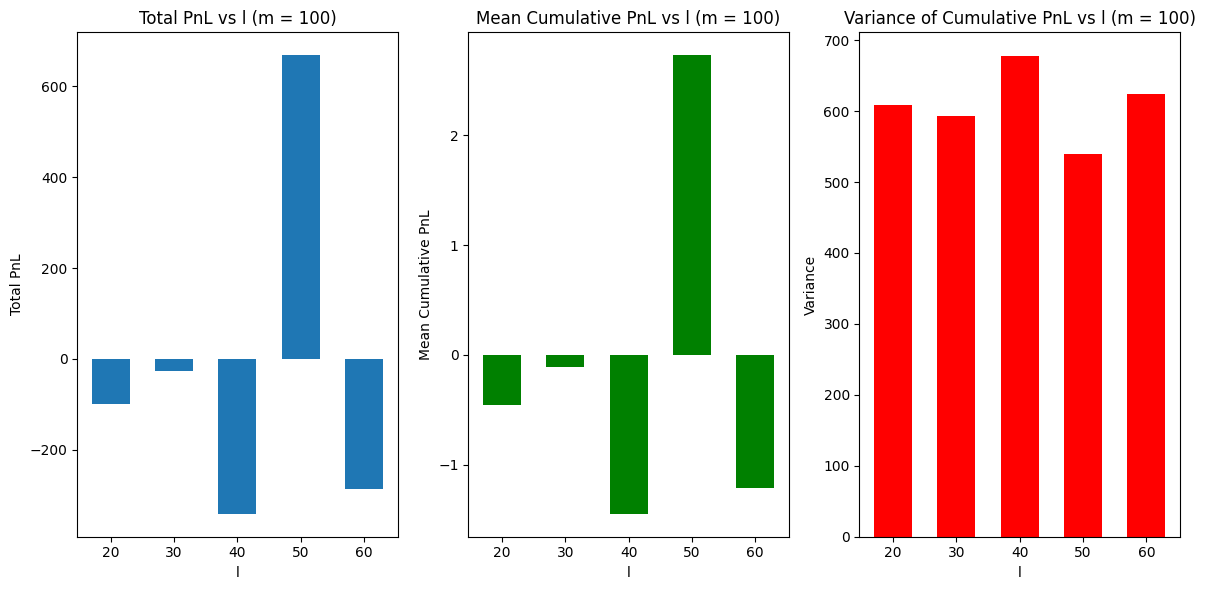

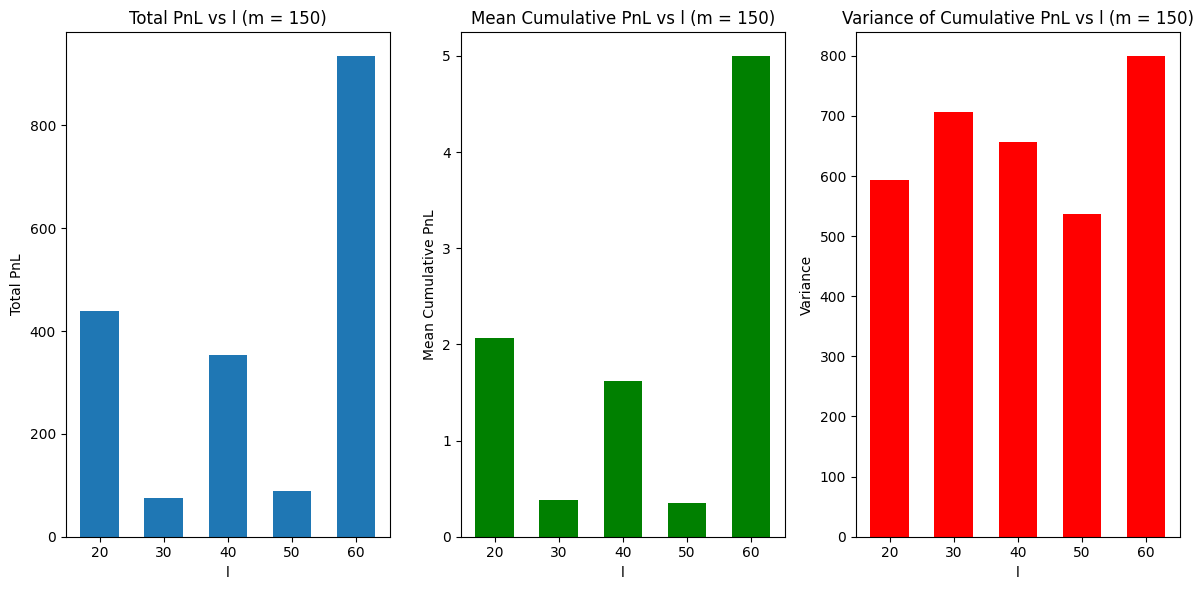

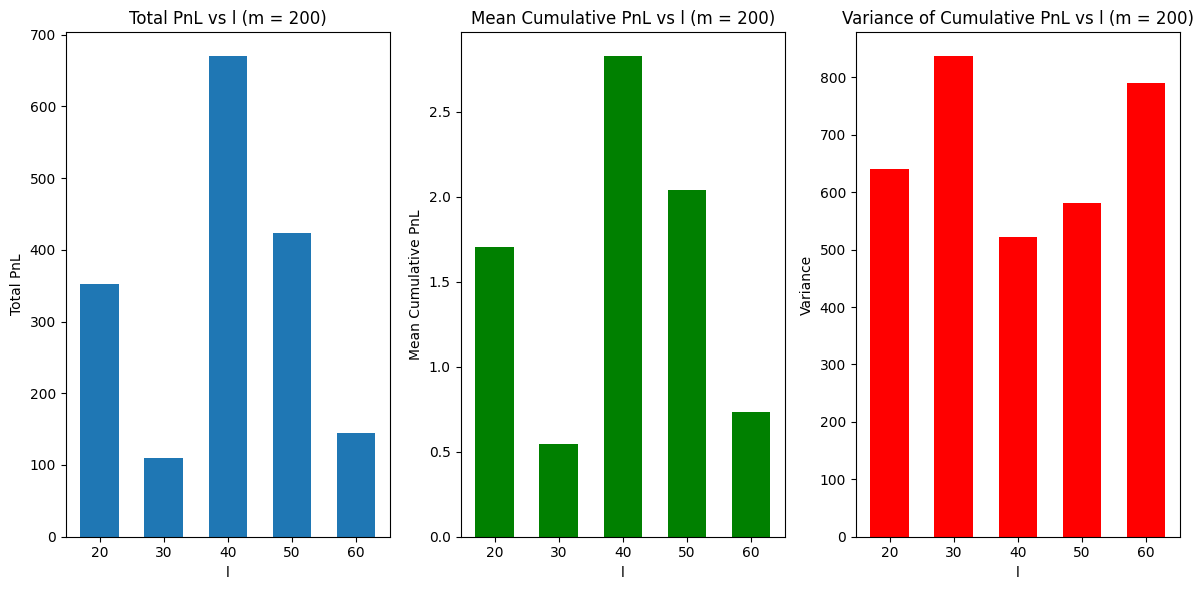

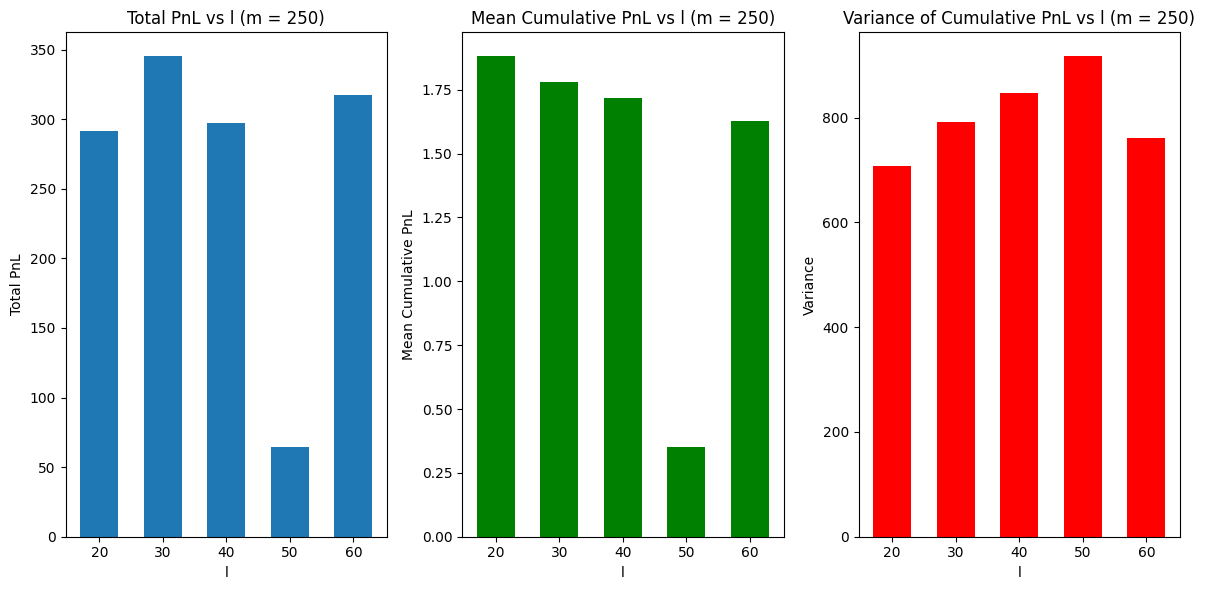

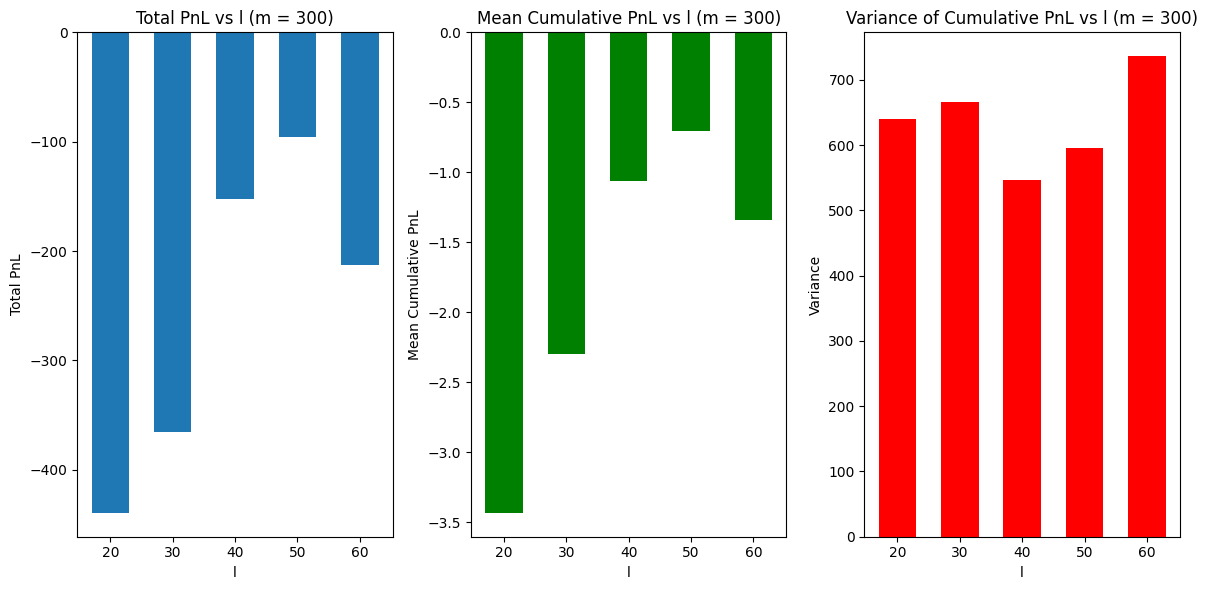

In [73]:
import numpy as np
import matplotlib.pyplot as plt

for fixed_train in result:
    if not fixed_train:
        continue  # Skip empty entries

    # Extract m from the first tuple
    m = fixed_train[0][0]

    l_values = []
    total_pnls = []
    mean_unit_pnls = []
    var_unit_pnls = []

    for fixed_test in fixed_train:
        _, l, total_pnl, cum_pnl_list = fixed_test

        cum_pnl_array = np.array(cum_pnl_list)
        mean_unit_pnl = np.mean(cum_pnl_array)
        var_unit_pnl = np.var(cum_pnl_array)

        l_values.append(l)
        total_pnls.append(total_pnl)
        mean_unit_pnls.append(mean_unit_pnl)
        var_unit_pnls.append(var_unit_pnl)

    # Sort by l for cleaner plots
    l_values = np.array(l_values)
    total_pnls = np.array(total_pnls)
    mean_unit_pnls = np.array(mean_unit_pnls)
    var_unit_pnls = np.array(var_unit_pnls)

    sort_idx = np.argsort(l_values)
    l_values = l_values[sort_idx]
    total_pnls = total_pnls[sort_idx]
    mean_unit_pnls = mean_unit_pnls[sort_idx]
    var_unit_pnls = var_unit_pnls[sort_idx]

    x = np.arange(len(l_values))  # X-axis positions for bars
    bar_width = 0.6

    # Plot as bar graphs
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.bar(x, total_pnls, width=bar_width)
    plt.xticks(x, l_values)
    plt.title(f"Total PnL vs l (m = {m})")
    plt.xlabel("l")
    plt.ylabel("Total PnL")

    plt.subplot(1, 3, 2)
    plt.bar(x, mean_unit_pnls, width=bar_width, color='green')
    plt.xticks(x, l_values)
    plt.title(f"Mean Cumulative PnL vs l (m = {m})")
    plt.xlabel("l")
    plt.ylabel("Mean Cumulative PnL")

    plt.subplot(1, 3, 3)
    plt.bar(x, var_unit_pnls, width=bar_width, color='red')
    plt.xticks(x, l_values)
    plt.title(f"Variance of Cumulative PnL vs l (m = {m})")
    plt.xlabel("l")
    plt.ylabel("Variance")

    plt.tight_layout()
    plt.show()


In [111]:
static_m_used = [trade['m'] for trade in static_trades]
static_l_used = [trade['l'] for trade in static_trades]
static_unit_pnl = [trade['pnl'] for trade in static_trades]

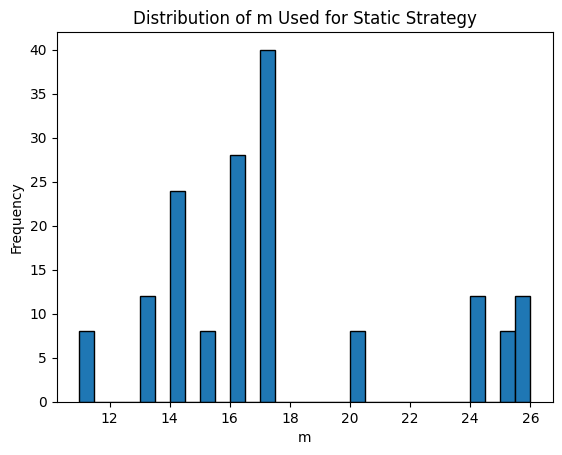

In [112]:
plt.hist(static_m_used, bins=30, edgecolor='black')
plt.xlabel('m')
plt.ylabel('Frequency')
plt.title('Distribution of m Used for Static Strategy')
plt.show()

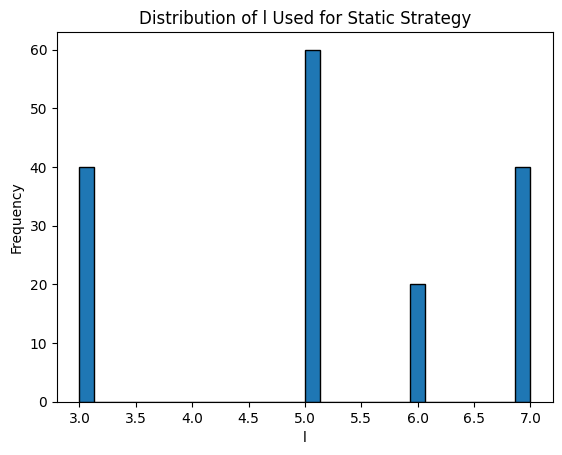

In [113]:
plt.hist(static_l_used, bins=30, edgecolor='black')
plt.xlabel('l')
plt.ylabel('Frequency')
plt.title('Distribution of l Used for Static Strategy')
plt.show()

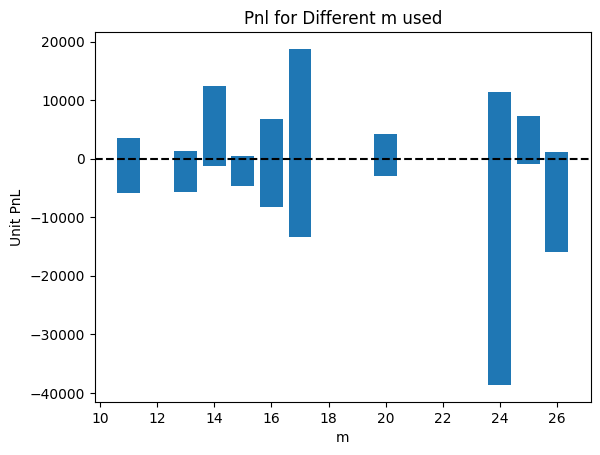

In [114]:
plt.bar(static_m_used, static_unit_pnl)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('m')
plt.ylabel('Unit PnL')
plt.title('Pnl for Different m used')
plt.show()

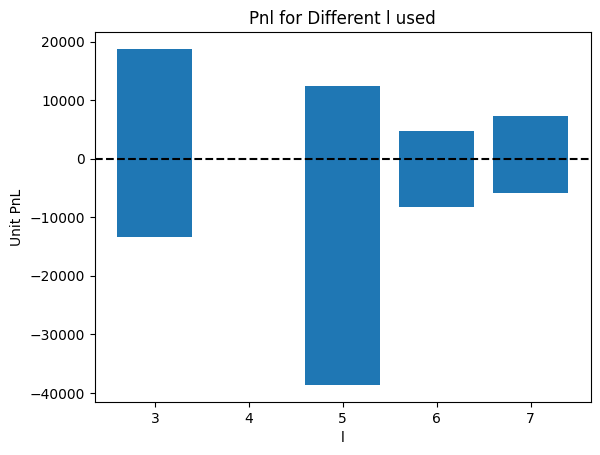

In [115]:
plt.bar(static_l_used, static_unit_pnl)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('l')
plt.ylabel('Unit PnL')
plt.title('Pnl for Different l used')
plt.show()

In [ ]:
def simulate_fixed_hotspot_full_run(bankroll, data_arr, m, l):
    """
    Run a naive DMD-based trading strategy without hotspot accuracy filtering.
    Every 4 days, uses the past 9 days to predict and trades based on that.
    
    Parameters:
        bankroll (int): Total bankroll to invest.
        data_arr (np.ndarray): [n_stocks+1, n_days] stock price matrix (including mean row).
        m (int): Number of past days to use for prediction (default=9).
        l (int): Holding period / prediction horizon (default=4).

    Returns:
        total_pnl (float): Total profit/loss from trading.
        trade_log (list): Each trade's details.
    """
    n_stocks = data_arr.shape[0] - 1
    total_days = data_arr.shape[1]
    total_pnl = 0.0
    trade_log = []
    
    day = m + 1  # first day with enough history

    while day + l <= total_days:
        M = data_arr[:n_stocks, day - m:day]
        M1 = M[:, :-1]
        M2 = M[:, 1:]

        # Predict using DMD
        pred = predict_price(M1, M2, l)
        actual = data_arr[:n_stocks, day:day + l]

        # Validate data (exclude NaNs)
        valid_idx = ~np.isnan(pred[:, -1]) & ~np.isnan(pred[:, 0]) & \
                    ~np.isnan(actual[:, 0]) & ~np.isnan(actual[:, -1])
        if not np.any(valid_idx):
            day += l
            continue

        delta = pred[valid_idx, -1] - pred[valid_idx, 0]
        direction = np.sign(delta)
        if np.all(direction == 0):
            day += l
            continue

        entry_prices = actual[:, 0][valid_idx]
        exit_prices  = actual[:, -1][valid_idx]
        per_stock_investment = bankroll / len(entry_prices)

        pnl = 0.0
        for j in range(len(entry_prices)):
            entry = entry_prices[j]
            exit  = exit_prices[j]
            dir_j = direction[j]
            if dir_j == 0:
                continue
            stock_return = (exit - entry) if dir_j > 0 else (entry - exit)
            pnl += stock_return / entry * per_stock_investment

        total_pnl += pnl
        trade_log.append({
            "entry_day": day,
            "exit_day": day + l - 1,
            "m": m,
            "l": l,
            "pnl": pnl
        })

        day += l  # advance to next trade window

    return total_pnl, trade_log


Total PnL using (m=9, l=3): $344.45


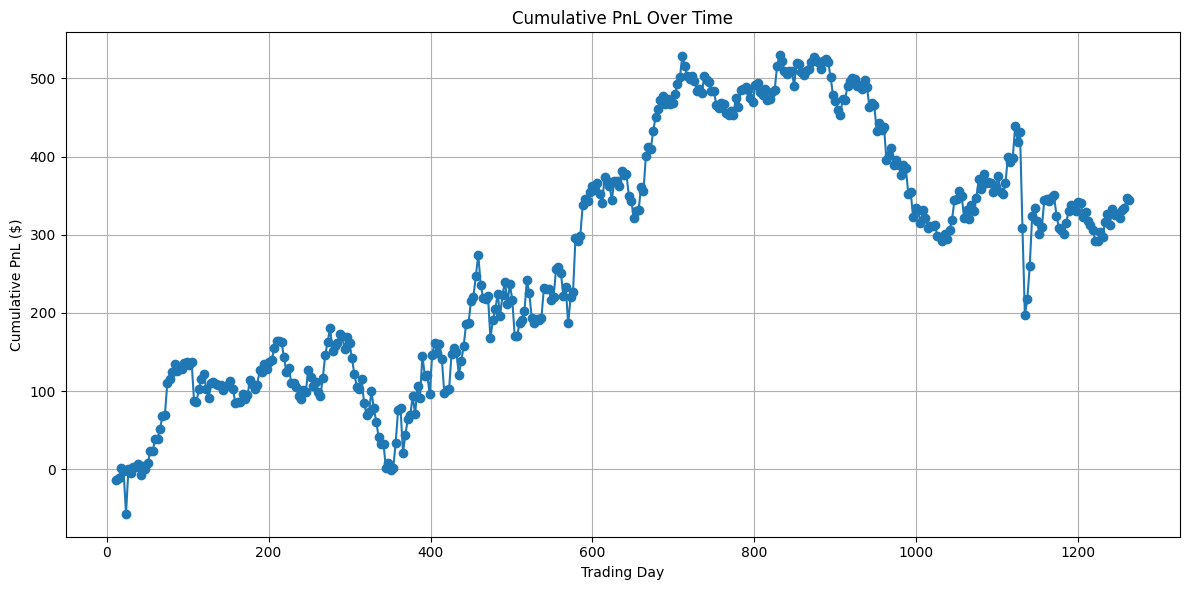

In [ ]:
pnl, trade_log = simulate_fixed_hotspot_full_run(
    bankroll=1000,
    data_arr=data_arr_samp,
    m=9,
    l=3
)

plot_pnl(trade_log)


In [ ]:
print(f"Completely Static PnL using (m=9, l=3): {pnl:.2f}")
print(f'Total Trades: {len(trade_log)}')

Completely Static PnL using (m=9, l=3): 344.45
Total Trades: 418


In [ ]:
def strategy_1(portfolio):
    '''
    Strategy 1: split up 10 years of data into 100 day increments.
    Then find a hotspot using the first 100 days, invest l future days; 
    recalibrate the hotspot after l days, and repeat on 10 years of data.
    '''
    hist_data_10_yrs = get_close_prices(portfolio)
    n = hist_data_10_yrs.shape[1]
    hist_data_10_yrs = hist_data_10_yrs[:, n//2:] # Use only the most recent 10 years of data

    delta = 0
    while delta < hist_data_10_yrs.shape[1]-100: #can adjust this 100 to change the number of days used to find hotspots
        data_arr = hist_data_10_yrs[:, delta:delta+100]
        accuracy_scores, potential_hotspots = find_hotspot(data_arr)
        if potential_hotspots:
            sorted_by_score = sorted(potential_hotspots, key=lambda tpl: tpl[2], reverse=True)
            #here we can build and call a function that checks if the average of its neighbors are also > 51% 
            #for now will just take the highest accuracy score and use the corresponding (m,l) as the hotspot
            m, l, accuracy = sorted_by_score[0]
            #build and call a function that invests and tracks P&L using (m,l) hotspot
            delta += l